<a href="https://colab.research.google.com/github/nhuang37/AdversarialAttack/blob/master/Jax_TheCannon_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A JAX implementation of *The Cannon*
by **David W. Hogg** (Flatiron), **Teresa Huang** (JHU) and **Soledad Villar** (JHU).

### Dependencies & Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My\ Drive/Adversarial_Attack

/content/drive/My Drive/Adversarial_Attack


In [31]:
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import jax
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from scipy.optimize import minimize #use scipy!

#from jax.scipy.optimize import minimize
#random seed
key = random.PRNGKey(42)
RCOND = 1e-15

In [4]:
!pip install astropy
!pip install astroNN

In [5]:
#[BUG: loader load numpy array - not jax array yet!]
from astroNN.datasets import H5Loader
from astroNN.apogee import aspcap_mask

# Load the training data
loader = H5Loader('__train_4k.h5')#H5Loader('__train_r_giant_1k_8575_1125_1557.h5')
loader.load_err = True
loader.target = ['teff', 'logg','Fe']
x_all,y_all,x_err,y_err = loader.load()

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


/usr/local/lib/python3.6/dist-packages/astroNN/datasets/h5.py:580: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.h5path) as F:  # ensure the file will be cleaned up
/usr/local/lib/python3.6/dist-packages/astroNN/datasets/h5.py:612: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.h5path) as F:  # ensure the file will be cleaned up


In [6]:
x_err.shape, y_err.shape

((4175, 7514), (4175, 3))

In [7]:
good_idx = (y_all[:,0] > 3500) & (y_all[:,1] != -9999) & (y_all[:,2] > -1.0)
x = x_all[good_idx]
y = y_all[good_idx]
x_ivar = 1/x_err[good_idx]**2

In [8]:
x.shape, y.shape

((3975, 7514), (3975, 3))

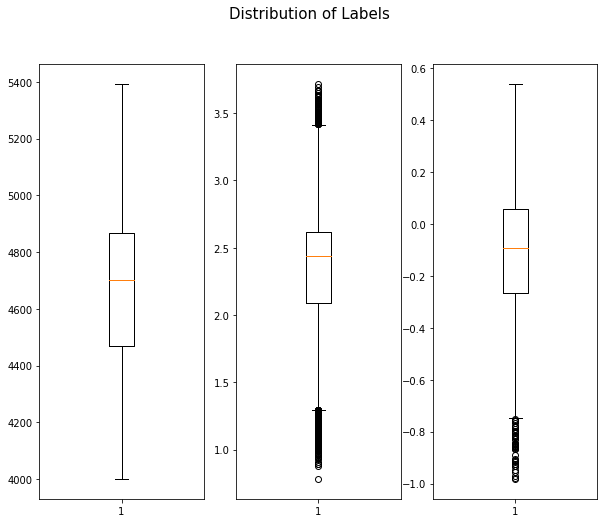

In [9]:
###Outliers
fig, axs = plt.subplots(ncols=3, figsize=(10,8))
for i in range(3):
  axs[i].boxplot(y[:,i])

fig.suptitle('Distribution of Labels', fontsize=15, y=0.98)
plt.show()

In [10]:
###train/test set
N = x.shape[0]
rs = jax.random.uniform(key=key, shape=[N])
thre = 0.8
I_train = rs < thre
I_test = rs > thre
###convert original numpy array (loaded from h5) to jax numpy array
x_test = np.array(x[I_test])
y_test = np.array(y[I_test])
x_ivar_test = np.array(x_ivar[I_test])
xs = np.array(x[I_train])
ys = np.array(y[I_train])
x_ivars = np.array(x_ivar[I_train])

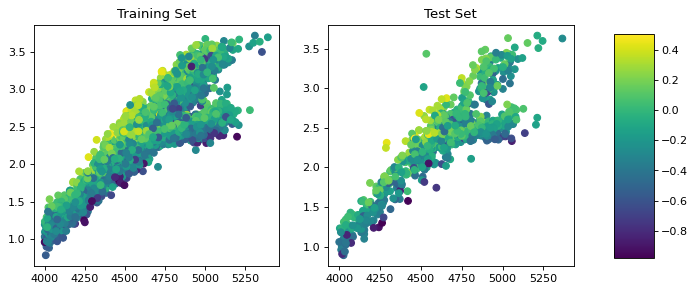

In [11]:
fig, axs = plt.subplots(ncols=2,figsize=(10,4), dpi=80)

for i, y in enumerate([ys, y_test]):
  im = axs[i].scatter(y[:,0], y[:,1], c=y[:,2])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

axs[0].set_title('Training Set')
axs[1].set_title('Test Set')
plt.show()

In [12]:
xs.shape, ys.shape, x_test.shape, y_test.shape, x_ivars.shape

((3221, 7514), (3221, 3), (754, 7514), (754, 3), (3221, 7514))

### TheCannon - powered by JAX

In [13]:
#only the labels
def shifts_and_scales(labels):
  N, K = labels.shape
  foo = np.nanpercentile(labels, [2.5, 50., 97.5], axis=0)
  return foo[1], 0.5 * (foo[2] - foo[0])

shifts, scales = shifts_and_scales(ys)
whys = (ys - shifts) / scales

In [14]:
print(shifts, scales)
print(shifts_and_scales(whys))

[ 4.7049663e+03  2.4378452e+00 -9.0646319e-02] [5.2465845e+02 1.1168355e+00 4.7462869e-01]
(DeviceArray([0., 0., 0.], dtype=float32), DeviceArray([1.0000001, 1.       , 1.       ], dtype=float32))


In [15]:
def vectorize(why):
  K = len(why)
  v = np.array([1., ])
  v = np.append(v, why)
  v = np.append(v, np.outer(why, why)[np.triu_indices(K)])
  return v
 
def design_matrix(whys):
  return vmap(vectorize)(whys)

In [16]:
%%time 
YY = design_matrix(whys)
print(YY.shape)

(3221, 10)
CPU times: user 167 ms, sys: 2.17 ms, total: 169 ms
Wall time: 168 ms


In [17]:
%%time
from functools import partial

@jit 
def train_one(YY, x, x_ivar):
    return np.linalg.lstsq(YY * np.sqrt(x_ivar)[:,None], x * np.sqrt(x_ivar), rcond=RCOND)[0] 

theta = vmap(partial(train_one, YY))(xs.T, x_ivars.T)

CPU times: user 708 ms, sys: 9.4 ms, total: 717 ms
Wall time: 716 ms


In [18]:
theta.shape

(7514, 10)

In [19]:
@jit
def test_objective(why, theta, x, x_ivar):
  """
  Compute test objective for one star
  """  
  resid = x - theta @ vectorize(why)
  return resid.T @ (resid * x_ivar)

def test_one(theta, x, x_ivar, K=3):
  """
  Test one star, using scipy minimize function
  """
  why0 = np.zeros(K) # magic initialization
  result = minimize(test_objective, why0, args=(theta, x, x_ivar), method="BFGS", jac=grad(test_objective)) #SCIPY minimize - support different methods
  return result.x

def test_all(theta,xs, x_ivars, K=3):
  """
  Test all stars
  """
  return np.array([test_one(theta, x, x_ivar, K=K) for x, x_ivar in zip(xs, x_ivars)])

In [20]:
%%time
ii = 17 # the most random number
whystar = test_one( theta, x_test[ii], x_ivar_test[ii])
ystar = whystar * scales + shifts
print(ystar, y_test[ii])

[ 4.5487305e+03  2.0668716e+00 -2.1513906e-01] [ 4.5239336e+03  2.0069244e+00 -1.9932619e-01]
CPU times: user 828 ms, sys: 55.1 ms, total: 883 ms
Wall time: 792 ms


In [21]:
#unit test for gradient 
derivative_fn = grad(test_objective)
print('gradient (JAX): ', derivative_fn(whystar,theta, x_test[ii+1],  x_ivar_test[ii+1]))

eps = 1e-3 #1e-3 is a good size!
diff = []
before = test_objective(whystar, theta, x_test[ii+1], x_ivar_test[ii+1])
for i in range(3):
  delta = np.eye(3) * eps
  after = test_objective(whystar + delta[i], theta, x_test[ii+1], x_ivar_test[ii+1])
  diff.append((after - before)/eps)

print('gradient (numeric): ', diff)

gradient (JAX):  [-508061.66    41653.855 -409455.1  ]
gradient (numeric):  [DeviceArray(-505999.97, dtype=float32), DeviceArray(41968.746, dtype=float32), DeviceArray(-408124.97, dtype=float32)]


In [22]:
%%time
why_stars = test_all(theta, x_test, x_ivar_test)
ystars = why_stars * scales + shifts

CPU times: user 4min 54s, sys: 42 s, total: 5min 36s
Wall time: 4min 12s


In [36]:
y_test[:,2].max(), 

DeviceArray(0.50477743, dtype=float32)

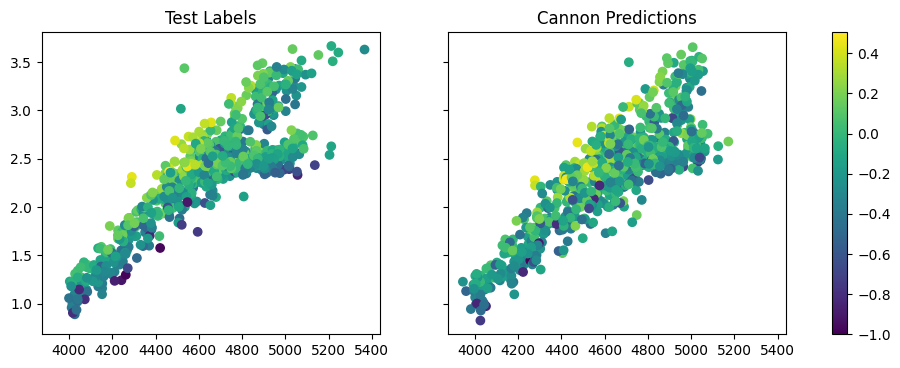

In [47]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=True, dpi=100)
for ax, y in zip(axs.flat, [y_test, ystars]):
    im = ax.scatter(y[:,0], y[:,1], c=y[:,2], vmin=-1, vmax = max(y_test[:,2].max(), ystars[:,2].max()))

axs[0].set_title('Test Labels')
axs[1].set_title('Cannon Predictions')
cax,kw = mpl.colorbar.make_axes([ax for ax in axs.flat])
plt.colorbar(im, cax=cax, **kw)
plt.show()

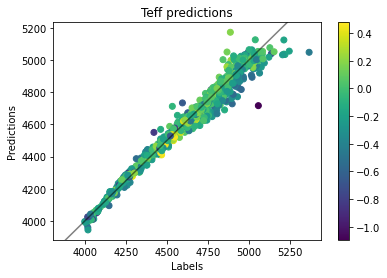

In [44]:
plt.scatter(y_test[:,0], ystars[:,0], c=ystars[:,2])
yy = plt.ylim()
plt.plot(yy, yy, 'k-', alpha=0.5)
plt.ylim(*yy)
plt.colorbar()
plt.title('Teff predictions')
plt.xlabel('Labels')
plt.ylabel('Predictions')
plt.show()

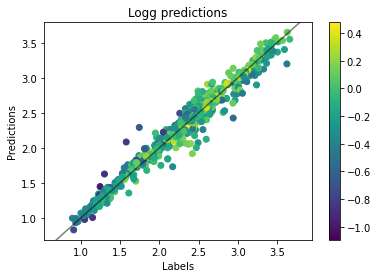

In [45]:
plt.scatter(y_test[:,1], ystars[:,1], c=ystars[:,2])
yy = plt.ylim()
plt.plot(yy, yy, 'k-', alpha=0.5)
plt.ylim(*yy)
plt.colorbar()
plt.title('Logg predictions')
plt.xlabel('Labels')
plt.ylabel('Predictions')
plt.show()

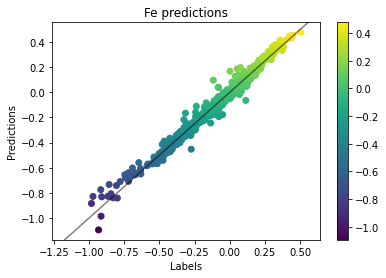

In [46]:
plt.scatter(y_test[:,2], ystars[:,2], c=ystars[:,2])
yy = plt.ylim()
plt.plot(yy, yy, 'k-', alpha=0.5)
plt.ylim(*yy)
plt.colorbar()
plt.title('Fe predictions')
plt.xlabel('Labels')
plt.ylabel('Predictions')
plt.show()

In [ ]:
%%time 
#[NOT-IMPLEMENTED - BUG: vmap on test set somehow doesn't work?]
# why_stars = vmap(partial(test_one, theta))(x_test[0:2], x_ivar_test[0:2]) 
# ystars = why_stars * scales + shifts